## Soft SVM with Gaussian Kernel

In [2]:
import numpy as np
import matplotlib.pyplot as plt #only used for plotting!!!
%matplotlib inline

from sklearn.datasets import make_blobs #only imported .dataset to generate the dataset, package is not used for anything else!!!

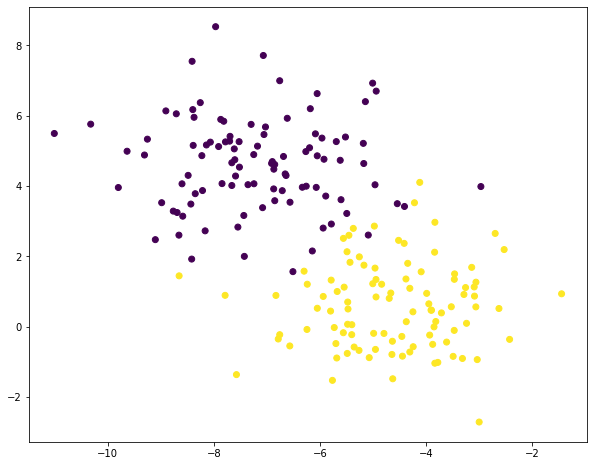

In [3]:
## generate data points
N = 200  # number of samples
D = 2  # number of dimensions
C = 2  # number of classes
seed = 12  # for reproducible experiments
cluster_std = 1.3#0.8
punish_const = 0.1

alpha_tol = 1e-4 # threshold for choosing support vectors

X, y = make_blobs(n_samples=N, n_features=D, centers=C, random_state=seed, cluster_std = cluster_std)
y[y == 0] = -1  # it is more convenient to have {-1, 1} as class labels (instead of {0, 1})
y = y.astype(np.float)
plt.figure(figsize=[10, 8])
plt.scatter(X[:,0], X[:, 1], c=y)
plt.show()

In [32]:
def gaussian(x1,x2, sigma=0.6):
    return np.exp(-np.linalg.norm(x1-x2)**2/(2*(sigma**2)))

In [26]:
from cvxopt import matrix, solvers

class soft_SVM_gauss(object):
    def __init__(self, kernel=gaussian, C=1.0):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y, alpha_tol):
        N, D = X.shape

        #calc outer product of y
        y_tmp = np.zeros((y.shape[0],y.shape[0]))
        for i in range(0,y.shape[0]):
            for j in range(0,y.shape[0]):
                y_tmp[i,j] = y[i]*y[j]

        #calc Gram matrix
        Gram = np.zeros((y.shape[0], y.shape[0]))
        for i in range(0,X.shape[0]):
            for j in range(0,X.shape[0]):
                Gram[i,j] = self.kernel(X[i],X[j])
        
        P = matrix(y_tmp*Gram) #positive defininte matrix which will be minimized
        q = matrix(-np.ones([N, 1])) #np array with ones

        G = matrix(np.vstack((-np.eye(N),np.eye(N))))
        h = matrix(np.hstack((np.zeros(N),np.ones(N)*self.C)))
        
        A = matrix(y.reshape(1,-1))
        b = matrix(np.zeros(1))

        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b) #solve the optimization problem
        self.alphas = np.array(solution['x']).flatten()

        #find support vectors
        support_vecs = (self.alphas > alpha_tol)
        ind = np.arange(len(self.alphas))[support_vecs]
        self.alphas = self.alphas[support_vecs] #save support vectors
        self.sv = X[support_vecs] #save coordinates of support vectors
        self.sv_y = y[support_vecs] #save labels of support vectors

    
        self.w = None

        #calc biases
        self.bias = 0
        for n in range(len(self.alphas)):
            self.bias = self.bias + self.sv_y[n]
            self.bias = self.bias - np.sum(self.alphas * self.sv_y * Gram[ind[n],support_vecs])
        self.bias = self.bias / len(self.alphas)
        print(f'bias is {self.b}')

    def project(self, X):
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                tmp = 0
                for alpha, sv_y, sv in zip(self.alphas, self.sv_y, self.sv):
                    tmp = tmp + alpha * sv_y * self.kernel(X[i], sv)
                y_predict[i] = tmp
            return y_predict + self.bias

In [28]:
if __name__ == "__main__":
    def generate_data(N, D, C, seed):
        X, y = make_blobs(n_samples=N, n_features=D, centers=C, random_state=seed, cluster_std=cluster_std)
        y[y == 0] = -1  
        return X, y.astype(np.float)

    def plot_svm(X, y, alpha, w, b, train=True):
        plt.figure(figsize=[10, 8])
        # Plot the hyperplane
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        x = np.linspace(X[:, 0].min(), X[:, 0].max())
        plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
        plt.plot(x, x * slope + intercept - 1/w[1], 'k--')
        plt.plot(x, x * slope + intercept + 1/w[1], 'k--')
        # Plot all the datapoints
        plt.scatter(X[:, 0], X[:, 1], c=y)
        # Mark the support vectors
        if train == True:
            support_vecs = alpha > alpha_tol
            plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.legend(loc='upper left')

    def plot_contour(X, y, svm_class):
        plt.figure(figsize=[10, 8])
        #plot datapoints
        plt.scatter(X[:,0], X[:,1], c=y)
        #create meshgrid for gaussian decision boundary
        X1, X2 = np.meshgrid(np.linspace(-11,-1,50), np.linspace(-2,8,50))
        X = np.array([[x1, x2] for x1, x2 in zip(X1.flatten(), X2.flatten())])
        Z = svm_class.project(X)
        Z = Z.reshape(X1.shape)
        plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        plt.axis("tight")

    def run_soft_svm(train,kernel):
        sampels, labels = generate_data(N, D, C, seed)
        X_train = sampels[:150]
        X_test = sampels[150:]
        y_train = labels[:150]
        y_test = labels[150:]

        soft_class_gaussian = soft_SVM_gauss(kernel)
        
        soft_class_gaussian.fit(X_train, y_train, alpha_tol)

        if train == True:
            plot_contour(X_train, y_train, soft_class_gaussian)
        else:
            plot_contour(X_test, y_test, soft_class_gaussian)

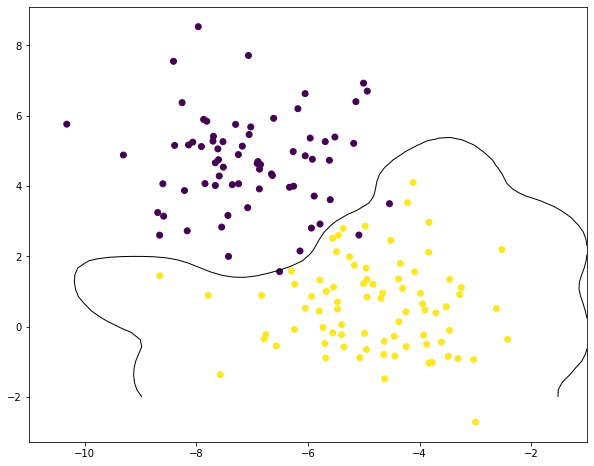

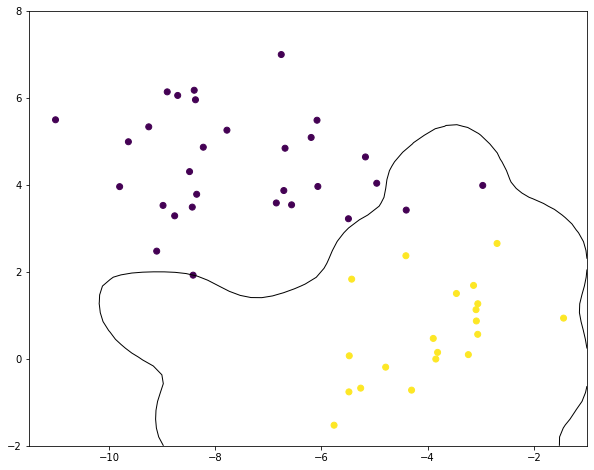

In [33]:
run_soft_svm(True, gaussian)
run_soft_svm(False, gaussian)